# Topic analysis

Detecting topics in the tweets during COVID-19 crisis by the diputados. 
It is used the cleaned dataset from the hypertext repository

In [1]:
# GLM analysis for count: https://dius.com.au/2017/08/03/using-statsmodels-glms-to-model-beverage-consumption/ To do with toxicity

# Imports and options

In [1]:
# General import
import os
import json
import re
import requests
from pathlib import Path
from datetime import date
import time 
from itertools import chain


from gensim.corpora import Dictionary
from gensim.models import TfidfModel


# Data imports
import numpy as np 
from numpy import save, load
import pickle


import pandas as pd 
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

import seaborn as sns

from sklearn import preprocessing


# Notebooks imports
from IPython.display import clear_output  # to avoid cluttering when using with tqdm. just put clear_output() at the end of the inside loop
from tqdm.auto import tqdm

In [2]:
%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_colwidth = 100

# Functions

In [3]:
# Need to check the URL to see the full one: 
def resolve_url(url):
    try:
        res = urllib2.urlopen(url)
        print(res)
        return res.geturl()
    except:
        return 'InvalidURL'

In [4]:
# To flatten the list of entities
def flatten_list(entities):
    return [item for sublist in entities for item in sublist]

# Loading data

In [5]:
root_filename = '01-2020_09-2020'

list_datasets = ["filtered_wo_rt"]

list_type_txt = ['txt_wo_entities']

In [6]:
# Load tweets to load
tweets_filename = './{}/data/{}_added_features.ftr'.format(root_filename, root_filename)
df = pd.read_feather(tweets_filename)
#df = df.sample(frac=sample_threshold, random_state=random_state)
try:
    del df['level_0']
except KeyError:
    pass

# Only get the party_5 from the begginning
# Size with party 5 only
df = df[df['party_5'].notnull()]

In [7]:
# Load users information
df_users = pd.read_csv('./data/full_users_info.csv')

In [8]:
# Merge the two dataframes
df = pd.merge(df, df_users[['user_id','full_name']], how='left', on=['user_id'])

In [9]:
# Load google toxicity scores
toxicity_filename = './{}/data/google_toxic_scores_wo_rt.csv'.format(root_filename)
df_tox = pd.read_csv(toxicity_filename)
df_tox.columns = ['id', 'toxicity', 'lang_google']

In [10]:
# Merge the two dataframes
df = pd.merge(df, df_tox, how='left', on=['id'])
df['toxicity_count'] = np.where(df['toxicity'] >= 0.4, 1, 0)

In [11]:
## Loading sentence embedding for visualisation purpose
for type_txt in list_type_txt:

    sent_emb_filename = "./{}/sentences_emb/sent_embeddings_{}_{}.npy".format(root_filename, type_txt, list_datasets[0]
    )
    sent_emb = load(sent_emb_filename)
    #len(sent_emb.tolist())
    #df['sent_emb_{}'.format(type_txt)] = sent_emb.tolist()
    print('{}: {}'.format(type_txt, len(sent_emb)))

txt_wo_entities: 104253


# Fix some columns

In [12]:
# Clean hashtags
covid_list = ['covid19', 'coronavirus', 'covid_19', 'covid2019','covid-19', 'covidー19']
df['hashtags'] = df['hashtags'].apply(lambda x: ['covid19' if i.lower() in covid_list else i.lower() for i in x])
df.shape

(486024, 27)

In [13]:
# Object time for the created_at column
df['created_at'] = pd.to_datetime(df['created_at'], format='%Y-%m-%d %H:%M:%S')


In [14]:
# Create lockdown variable
df['lockdown'] = np.where(( (df['created_at'].dt.date >= date(2020,2,14)) & (df['created_at'].dt.date < date(2020,3,14))),'pre-lockdown',
                     (np.where( ((df['created_at'].dt.date >= date(2020,3,14)) & (df['created_at'].dt.date <= date(2020,6,21))),'lockdown',
                         (np.where( ((df['created_at'].dt.date < date(2020, 6, 21))& (df['created_at'].dt.date <= date(2020,7,21))), 'post-lockdown',
                          None )))))

In [15]:
df['lockdown'].value_counts()

lockdown         257782
post-lockdown     76844
pre-lockdown      48799
Name: lockdown, dtype: int64

# Filtering data

In [16]:
# All data
df.shape

(486024, 28)

In [17]:
# With at least 5 words in the tweet
word_count_count = df[(df['word_count'] >=5)].shape[0]

In [18]:
# Labelled as Spanish with 0.6 certainty
spanish_count = df[(df['lang_label'] == 'es') & (df['lang_proba'] >= 0.6) & (df['word_count'] >=5)].shape[0]

In [19]:
# Not Retweet
not_rt_count = df[(df['rt_status'] == False) & (df['lang_label'] == 'es') & (df['lang_proba'] >= 0.6) & (df['word_count'] >=5)].shape[0]

In [20]:
df['include'] = (df['rt_status'] == False) & (df['lang_label'] == 'es') & (df['lang_proba'] >= 0.6) & (df['word_count'] >=5)

In [21]:
df['include'].value_counts()

False    381771
True     104253
Name: include, dtype: int64

In [22]:
# Check if the length of the included tweets are equal to the size of the sent_emb
assert df['include'].sum() == len(sent_emb)

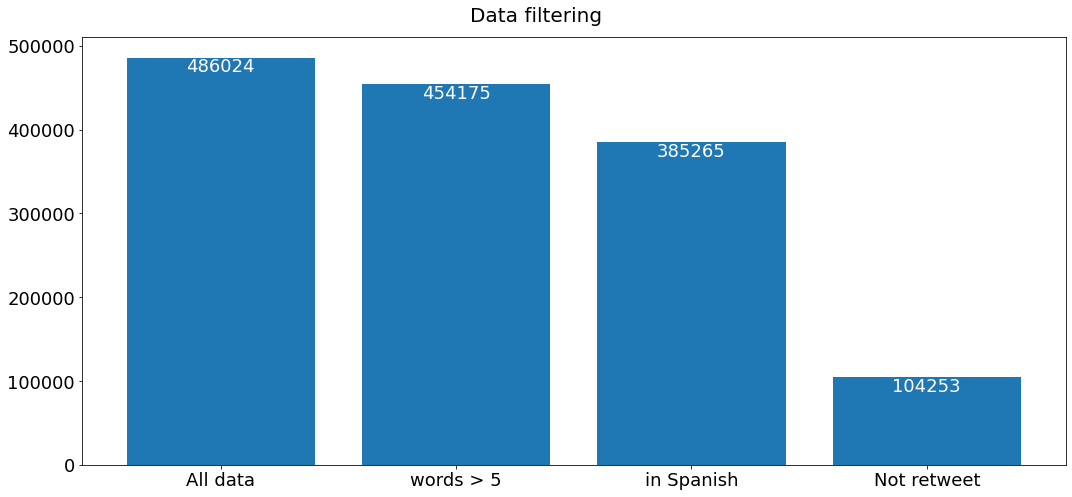

In [23]:
x_data = ['All data', 'words > 5', 'in Spanish', 'Not retweet']
y_data = [df.shape[0], word_count_count, spanish_count, not_rt_count]
fig, ax = plt.subplots(figsize=(15, 7))
fig.suptitle('Data filtering', fontsize=20)

plt.bar(x_data, y_data)
#for i, v in enumerate(y):
 #   ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height}', (x + width/2, height), va='top', ha='center', fontsize=18, color='white')

ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
#fig.subplots_adjust(top=0.88)
fig.tight_layout()
plt.savefig("./{}/plots/data_filtering.svg".format(root_filename), format="svg")
plt.show()
#plt.grid(None)

In [24]:
filtered_data = pd.DataFrame({'Filtering':x_data, 'count':y_data})
filtered_data.to_csv('./{}/outputs/filtering_data.csv'.format(root_filename))
filtered_data

,Filtering,count
0,All data,486024
1,words > 5,454175
2,in Spanish,385265
3,Not retweet,104253


In [25]:
# Filtering only the include
df = df[df['include'] == True]
df.columns

Index(['index', 'id', 'user_id', 'rt_status', 'text', 'lang_twitter', 'screen_name', 'user_mentions', 'hashtags', 'urls', 'created_at', 'txt_wo_entities', 'lang_label', 'lang_proba', 'token_txt', 'word_count', 'gender', 'party', 'provincia', 'party_5', 'include', 'hashtags_clean', 'label_hdbscan', 'full_name', 'toxicity', 'lang_google', 'toxicity_count', 'lockdown'], dtype='object')

## Checking the number of users comparatively to the initial list

In [26]:
tweet_per_users = df[['screen_name', 'full_name']].groupby(['full_name', 'screen_name']).size().to_frame().reset_index()
tweet_per_users.columns = ('Full Name', 'Twitter name', 'Nbr of tweets')
tweet_per_users = tweet_per_users.sort_values(by='Nbr of tweets', ascending=False)
tweet_per_users.to_csv('./{}/outputs/tweets_per_user.csv'.format(root_filename),index=False)
tweet_per_users.head()

,Full Name,Twitter name,Nbr of tweets
260,Víctor Sánchez del Real,sanchezdelreal,3273
137,Luis Gestoso,luisgestoso,2623
65,Francisco Jose Alcaraz Martos,fjosealcaraz,2028
3,Agustín Rosety Fernández de Castro,agustinrosety,1904
74,Guillermo Díaz Gómez,guillermodiazcs,1826


# Checking if tweets contains valuable text


In [27]:
print("Word Count Median: " + str(df['word_count'].median()))
print(df['word_count'].describe())

Word Count Median: 17.0
count    104253.000000
mean         16.436880
std           4.402876
min           5.000000
25%          14.000000
50%          17.000000
75%          20.000000
max          29.000000
Name: word_count, dtype: float64


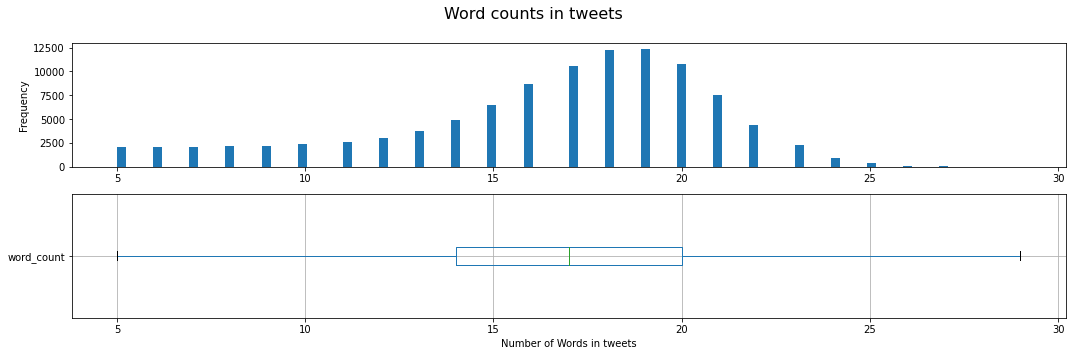

In [28]:
n_bins = 100

fig = plt.figure(figsize=(15,5))
fig.suptitle("Word counts in tweets ", fontsize=16)

plt.subplot(2, 1, 1)

plt.hist(df['word_count'], bins=n_bins)
plt.ylabel('Frequency')

plt.subplot(2, 1, 2)

df['word_count'].to_frame().boxplot(vert=False)
plt.xlabel('Number of Words in tweets')

fig.tight_layout()
fig.subplots_adjust(top=0.88)

plt.savefig("./{}/plots/word_counts.svg".format(root_filename), format="svg")
plt.show()

# Frequency count on the entities

/home/olivier/git/datapop/covidTopics/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


<AxesSubplot:xlabel='created_at'>

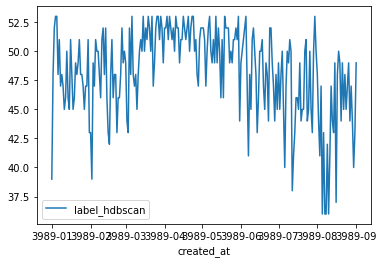

In [29]:
# Get the total of unique topic per day 

df_unique_per_day = df.groupby(df['created_at'].dt.date).agg({"label_hdbscan": pd.Series.nunique})
df_unique_per_day.plot()

In [30]:
df_time = df[df['label_hdbscan'] != -1][['toxicity', 'toxicity_count']].groupby([df['created_at'].dt.date, df['label_hdbscan'], df['party_5']]).agg(['sum', 'count']).reset_index().set_index('created_at').drop(columns=('toxicity_count', 'count'))
df_time.head(100)

label_hdbscan party_5  toxicity       toxicity_count
                                       sum count            sum
created_at                                                     
2020-01-01           0.0    PSOE  0.024784     1              0
2020-01-01           0.0     VOX  0.568267     2              1
2020-01-01           1.0      Cs  0.000000     0              0
2020-01-01           1.0      PP  0.417136     1              1
2020-01-01           1.0    PSOE  0.350558     1              0
2020-01-01           1.0     VOX  0.577260     1              1
2020-01-01           2.0      UP  0.742588     1              1
2020-01-01           2.0     VOX  0.769668     1              1
2020-01-01           3.0    PSOE  0.088555     1              0
2020-01-01           3.0     VOX  0.055863     1              0
2020-01-01           4.0  Altres  0.024583     1              0
2020-01-01           4.0      Cs  0.060604     1              0
2020-01-01           4.0     VOX  0.046990     1              0
2020-01-01           6.0    PSOE  0.024233     1              0
2020-01-01           6.0     VOX  0.191892     1              0
2020-01-01           8.0      Cs  0.125388     1              0
2020-01-01           8.0     VOX  0.102434     1              0
2020-01-01          10.0    PSOE  0.250189     1              0
2020-01-01          11.0      Cs  0.063412     1              0
2020-01-01          11.0      PP  0.186386     1              0
2020-01-01          11.0      UP  0.046990     1              0
2020-01-01          11.0     VOX  0.809120     3              1
2020-01-01          13.0    PSOE  0.479340     1              1
2020-01-01          14.0     VOX  0.870626     1              1
2020-01-01          15.0      Cs  0.132509     1              0
2020-01-01          15.0      PP  0.074717     1              0
2020-01-01          15.0    PSOE  0.755414     1              1
2020-01-01          15.0      UP  0.763712     1              1
2020-01-01          16.0      PP  0.024485     1              0
2020-01-01          16.0     VOX  1.310106     3              2
2020-01-01          17.0  Altres  0.194949     1              0
2020-01-01          17.0      Cs  0.046990     1              0
2020-01-01          17.0      PP  0.276657     1              0
2020-01-01          17.0    PSOE  0.135468     1              0
2020-01-01          17.0     VOX  0.046990     1              0
2020-01-01          19.0      Cs  0.066633     1              0
2020-01-01          19.0     VOX  0.011178     1              0
2020-01-01          20.0    PSOE  0.000000     0              0
2020-01-01          21.0     VOX  0.350558     1              0
2020-01-01          23.0      Cs  0.403726     1              1
2020-01-01          24.0      Cs  0.047816     1              0
2020-01-01          24.0     VOX  0.115554     1              0
2020-01-01          25.0      UP  0.000000     0              0
2020-01-01          26.0  Altres  0.136156     1              0
2020-01-01          27.0      Cs  0.126491     1              0
2020-01-01          27.0      PP  0.622248     1              1
2020-01-01          28.0      Cs  0.021182     1              0
2020-01-01          28.0     VOX  0.531673     1              1
2020-01-01          29.0      PP  0.079126     1              0
2020-01-01          29.0    PSOE  0.046990     1              0
2020-01-01          30.0  Altres  0.484944     1              1
2020-01-01          30.0      Cs  0.124091     1              0
2020-01-01          30.0      PP  0.398215     3              0
2020-01-01          30.0    PSOE  1.561133     8              2
2020-01-01          30.0      UP  0.761457     1              1
2020-01-01          30.0     VOX  1.340956     6              1
2020-01-01          31.0      Cs  0.403726     1              1
2020-01-01          32.0      PP  0.194996     1              0
2020-01-01          32.0    PSOE  0.018299     1              0
2020-01-01          32.0     VOX  0.660314 

In [31]:
# Good way to get columns for different categories and count 
# Way to have each categories per columns
df_time.index = pd.to_datetime(df_time.index, dayfirst=True, infer_datetime_format = True)

a = df_time.groupby([df_time.index.to_period('d')])['label_hdbscan'].value_counts(normalize=True).unstack().fillna(0)



a = a.reset_index().set_index('created_at')
a.head()

label_hdbscan,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,50.0,51.0
created_at,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-01,0.021978,0.043956,0.021978,0.021978,0.032967,0.000000,0.021978,0.000000,0.021978,0.000000,0.010989,0.043956,0.000000,0.010989,0.010989,0.043956,0.021978,0.054945,0.000000,0.021978,0.010989,0.010989,0.000000,0.010989,0.021978,0.010989,0.010989,0.021978,0.021978,0.021978,0.065934,0.010989,0.032967,0.021978,0.065934,0.000000,0.000000,0.000000,0.032967,0.032967,0.000000,0.054945,0.021978,0.010989,0.000000,0.021978,0.021978,0.000000,0.000000,0.032967,0.021978,0.000000
2020-01-02,0.027027,0.018018,0.018018,0.009009,0.018018,0.027027,0.027027,0.000000,0.027027,0.018018,0.027027,0.027027,0.027027,0.009009,0.018018,0.027027,0.009009,0.009009,0.000000,0.018018,0.000000,0.009009,0.018018,0.009009,0.009009,0.036036,0.027027,0.009009,0.027027,0.009009,0.054054,0.018018,0.027027,0.054054,0.036036,0.009009,0.009009,0.000000,0.018018,0.018018,0.018018,0.045045,0.018018,0.018018,0.018018,0.036036,0.018018,0.009009,0.009009,0.027027,0.027027,0.000000
2020-01-03,0.019231,0.019231,0.019231,0.019231,0.025641,0.000000,0.019231,0.019231,0.025641,0.025641,0.012821,0.038462,0.006410,0.012821,0.025641,0.025641,0.025641,0.006410,0.006410,0.032051,0.012821,0.012821,0.012821,0.006410,0.019231,0.019231,0.006410,0.019231,0.019231,0.012821,0.032051,0.019231,0.019231,0.032051,0.025641,0.012821,0.006410,0.019231,0.032051,0.012821,0.012821,0.032051,0.032051,0.025641,0.025641,0.025641,0.019231,0.019231,0.012821,0.025641,0.012821,0.019231
2020-01-04,0.026596,0.021277,0.015957,0.010638,0.010638,0.015957,0.005319,0.010638,0.015957,0.031915,0.021277,0.026596,0.010638,0.010638,0.015957,0.026596,0.010638,0.010638,0.005319,0.021277,0.010638,0.026596,0.021277,0.010638,0.021277,0.015957,0.010638,0.015957,0.026596,0.031915,0.031915,0.015957,0.026596,0.031915,0.021277,0.010638,0.010638,0.015957,0.021277,0.015957,0.021277,0.031915,0.021277,0.015957,0.021277,0.031915,0.026596,0.026596,0.021277,0.026596,0.026596,0.010638
2020-01-05,0.022989,0.022989,0.022989,0.011494,0.028736,0.017241,0.028736,0.011494,0.017241,0.017241,0.022989,0.034483,0.005747,0.011494,0.022989,0.017241,0.005747,0.022989,0.005747,0.022989,0.017241,0.017241,0.017241,0.011494,0.011494,0.022989,0.011494,0.028736,0.022989,0.017241,0.034483,0.017241,0.017241,0.034483,0.028736,0.005747,0.017241,0.022989,0.017241,0.017241,0.011494,0.034483,0.011494,0.011494,0.022989,0.017241,0.022989,0.022989,0.017241,0.034483,0.017241,0.011494


<AxesSubplot:xlabel='created_at'>

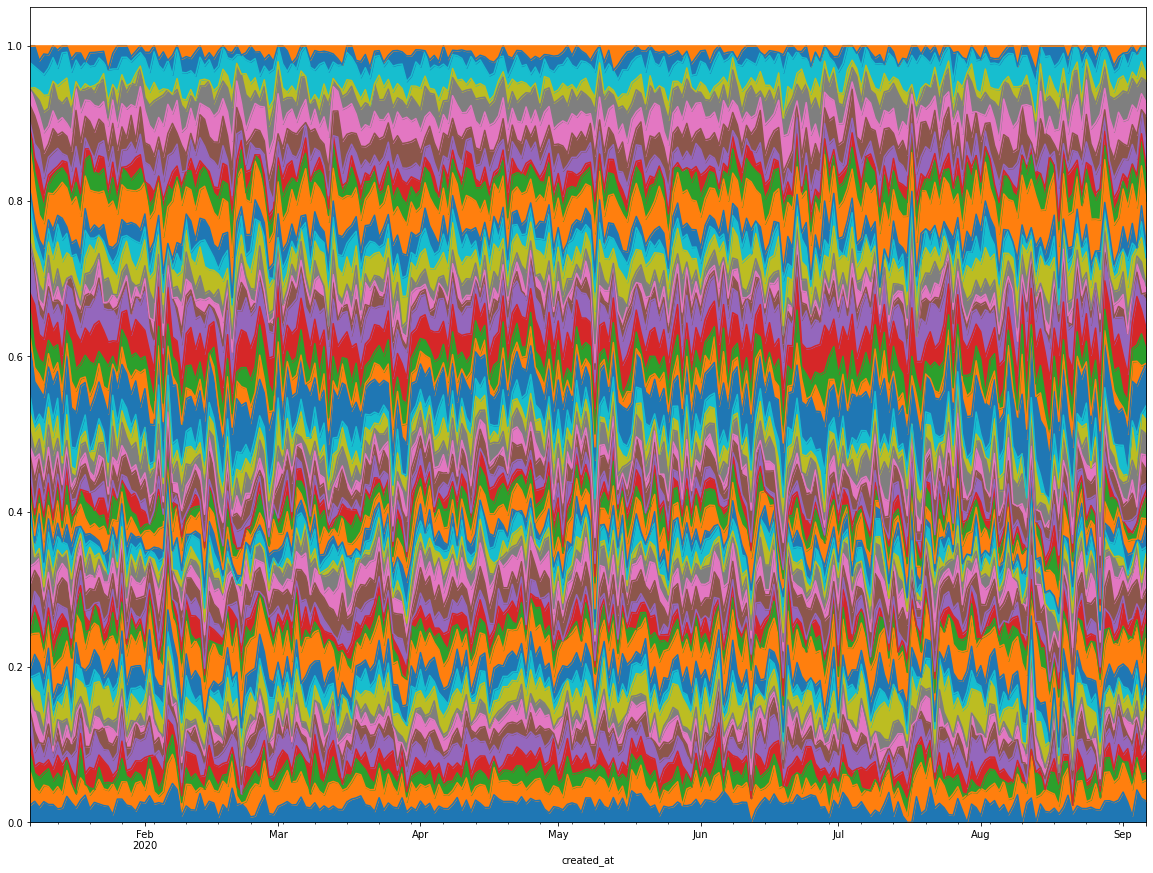

In [32]:
a = df_time.groupby([df_time.index.to_period('7D')])['label_hdbscan'].value_counts(normalize=True).unstack().fillna(0)

fig, ax = plt.subplots(figsize=(20,15))
a.plot.area(ax=ax, legend=False)



KeyError: ('label_hdbscan', 'party_5')

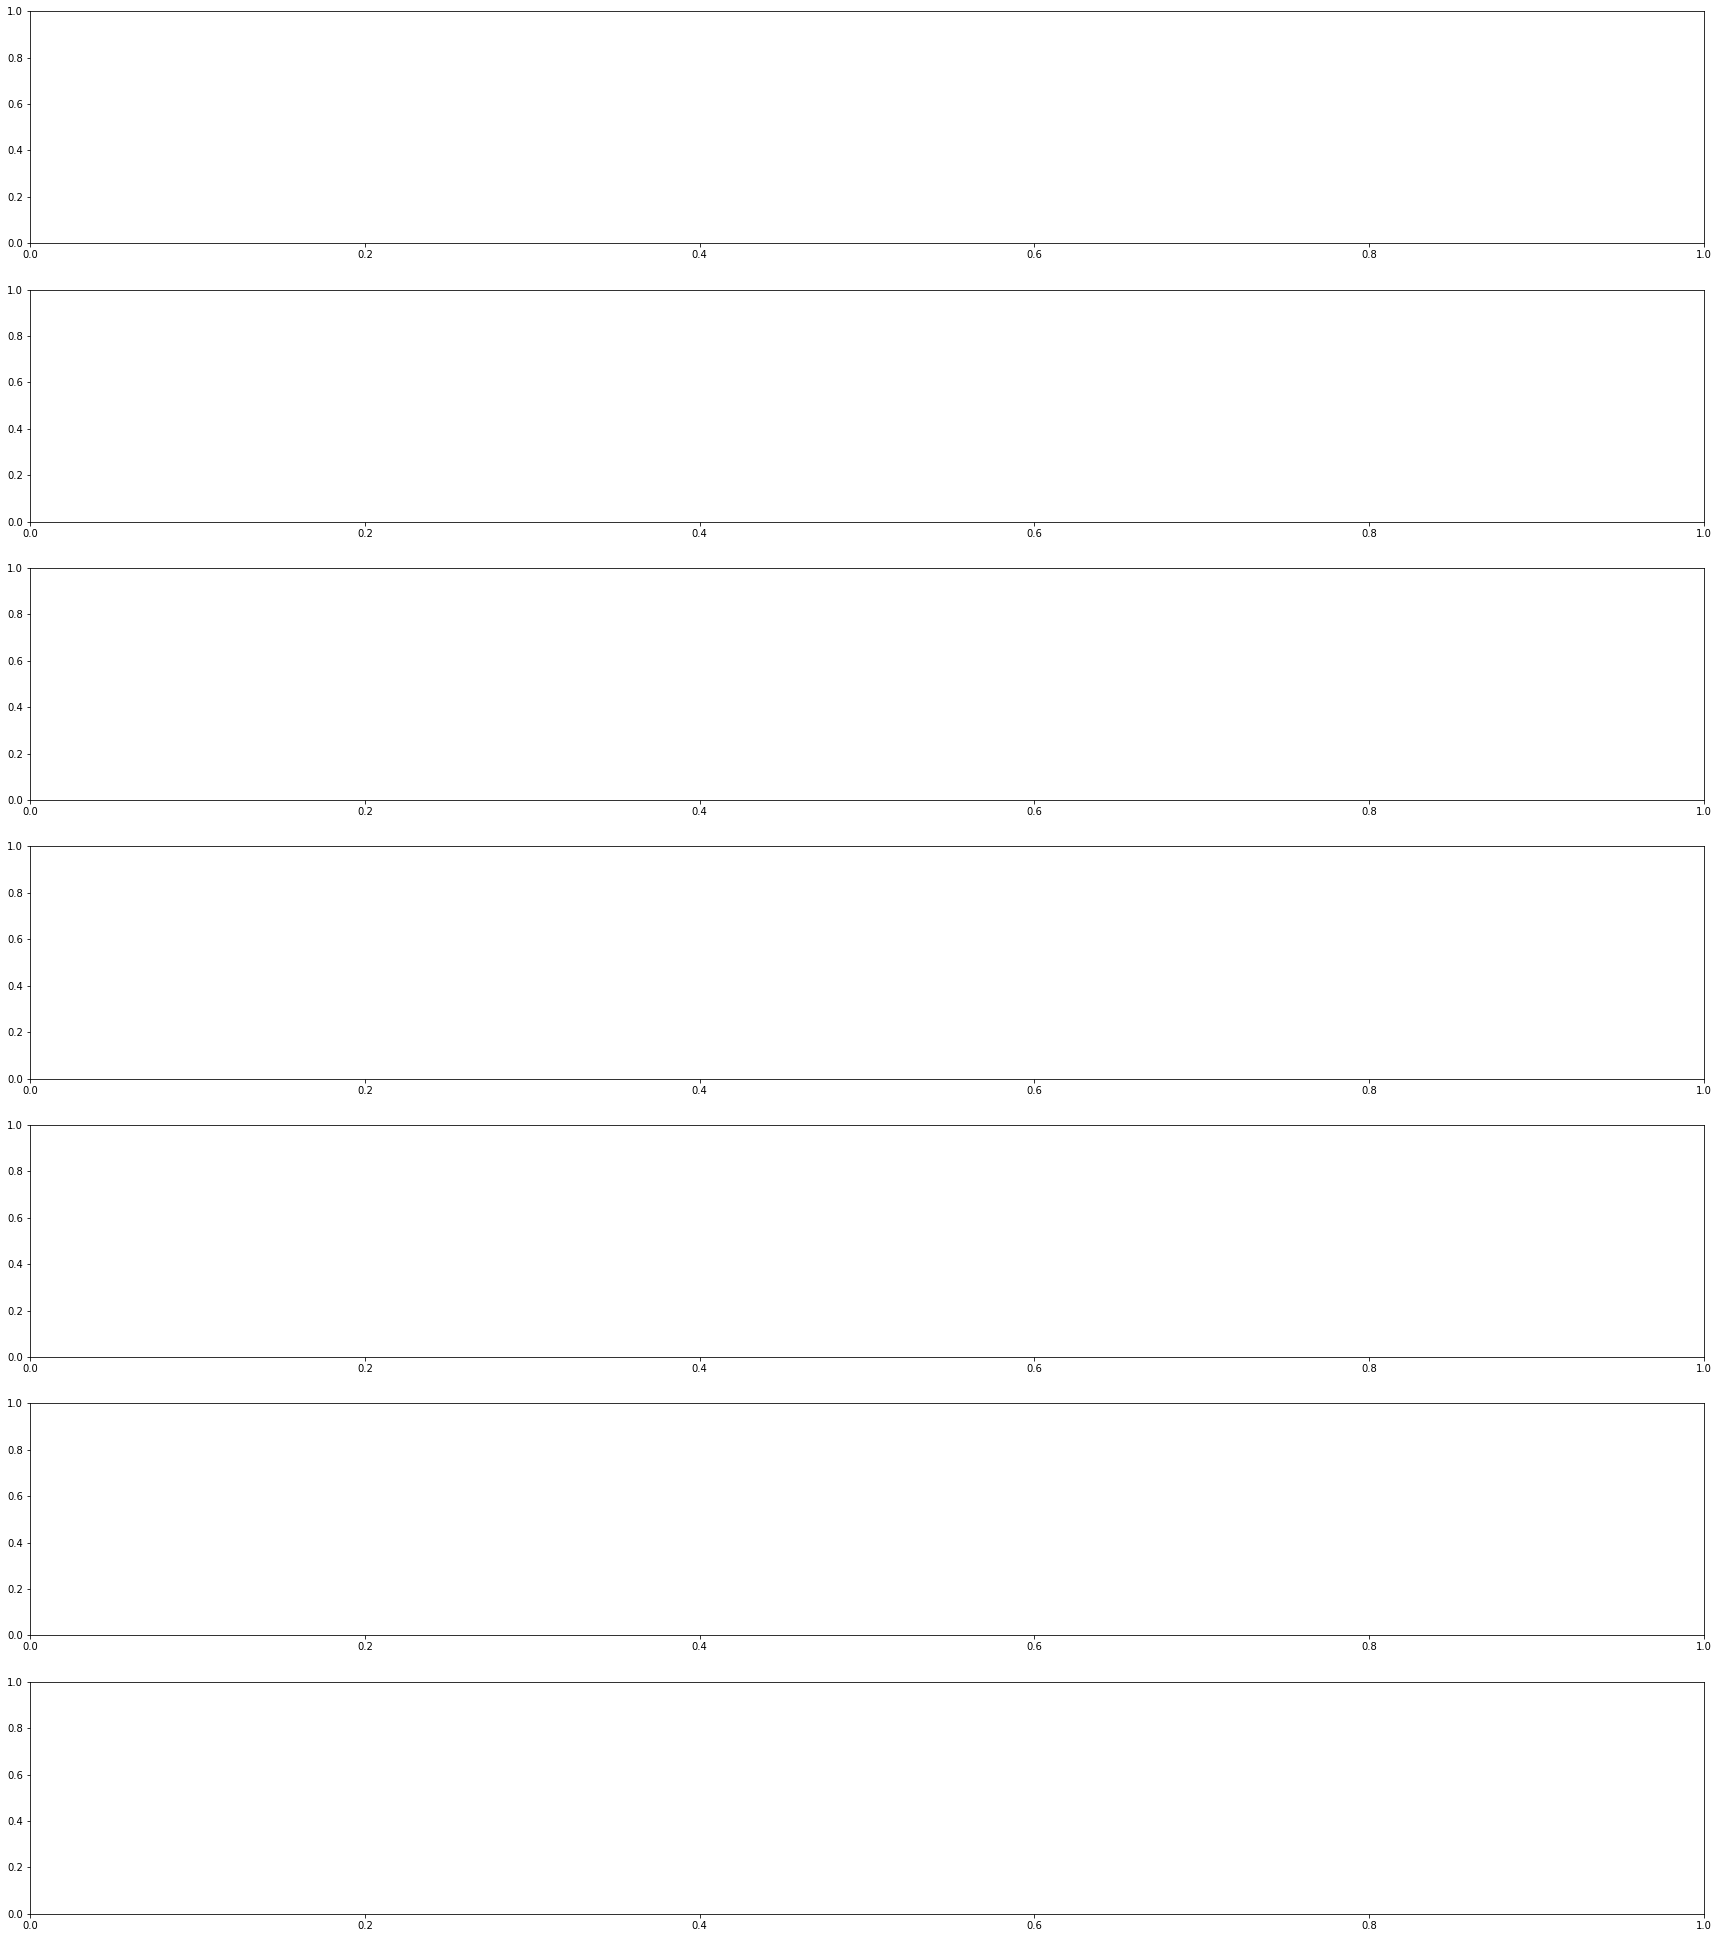

In [33]:
top10_labels = df[df['label_hdbscan'] != -1]['label_hdbscan'].value_counts().nlargest(10)#.index[2:]
# Way to have each categories per columns
df_to_plot = df[df['label_hdbscan'].isin(top10_labels.index)]



df_to_plot = df[df['label_hdbscan'].isin(top10_labels.index)][['toxicity', 'toxicity_count']].groupby([df['created_at'].dt.date, df['label_hdbscan'], df['party_5']]).agg(['sum', 'count']).reset_index().set_index('created_at').drop(columns=('toxicity_count', 'count'))
df_to_plot.index = pd.to_datetime(df_to_plot.index, dayfirst=True, infer_datetime_format = True)

#a = df_to_plot.groupby([df_to_plot.index.to_period('7D'), 'party_5'])['label_hdbscan'].value_counts(normalize=False).unstack().fillna(0)#.set_index('created_at')

#a = a.drop()

fig, axs = plt.subplots(7, figsize=(30,35))

for i, party in enumerate(a[('label_hdbscan', 'party_5')].unique()):
    print(party)
    df_test = a[a['party_5'] == party ]
    del df_test['party_5']

    df_test.plot.area(ax=axs[i])
#df_to_plot


In [ ]:
# Create a percentage per day for all cat
a_perc = a.divide(a.sum(axis=1), axis=0).fillna(0)#.reset_index()
#a_perc = a_perc.rename(columns={'level_1':'date'})
#a_perc.set_index('date')#.set_index('date')

#df = df.set_index(['a','b'])
#a_perc.columns = a_perc.columns.droplevel(0)
#df = df.reset_index()


In [ ]:
# Create the list of data per columns and the labels to plot
a_perc= a_perc.reset_index()
a_perc.head()

In [ ]:
#for party in a_perc['party_5'].unique():
plt.figure(figsize=(20,15))
data = [a_perc[col] for col in a_perc.columns]
labels = a_perc.columns
plt.stackplot(a_perc.index, data,
              labels=labels,
              alpha=0.8)
plt.legend()

#plt.show()

In [ ]:
# Doing the same without the two main topics to see if there is a more changes
try:
    del a[57]
except KeyError:
    pass
try:
    del a[14]
except KeyError:
    pass
# Create a percentage per day for all cat
a_perc = a.divide(a.sum(axis=1), axis=0)
# Create the list of data per columns and the labels to plot
data = [a_perc[col] for col in a_perc.columns]
labels = a_perc.columns
plt.figure(figsize=(20,15))
plt.stackplot(a_perc.index, data,
              labels=labels,
              alpha=0.8)
plt.legend()

plt.show()

## Mentions
Who are the most often mentioned accounts

In [ ]:
mentions = pd.Series(flatten_list(df['user_mentions']))

mentions.value_counts().describe()

In [ ]:
fig = plt.figure(figsize=(15,5))

plt.title('Frequencies of mentions')

plt.subplot(1, 2, 1)
# Create bars
mentions.value_counts().hist(bins=50)
plt.subplot(1, 2, 2)
mentions.value_counts().to_frame().boxplot(vert=False)

plt.show()

In [ ]:
Q1 = np.percentile(mentions.value_counts(), 1, interpolation = 'midpoint') 

Q25 = np.percentile(mentions.value_counts(), 25, interpolation = 'midpoint') 
  
Q75 = np.percentile(mentions.value_counts(), 75, interpolation = 'midpoint') 

Q99 = np.percentile(mentions.value_counts(), 99, interpolation = 'midpoint') 
  
# Interquaritle range (IQR) 
IQR = Q75 - Q25
  
print("Q1: {} - Q25: {} - Q75: {} - Q99: {}".format(Q1, Q25, Q75, Q99))

In [ ]:
df_mentions = mentions.value_counts().to_frame().reset_index()
df_mentions.columns = ["mentions", 'count']

In [ ]:
df_mentions.head(50)

In [ ]:
x = df_mentions['mentions'].head(100)
y = df_mentions['count'].head(100)
fig, ax = plt.subplots(figsize=(15, 15))
fig.suptitle('100 most mentioned Twitter users', fontsize=16)

plt.barh(x, y)
ax.invert_yaxis()
#plt.xticks(rotation=90)
plt.tight_layout()
#plt.axis('off')

#plt.grid(None)
plt.show()

### URLS

In [ ]:
# Need the tweet object to find which URL they share

In [ ]:
# Parsing them and create a dictionary with original: resolved.
# Then check if several point to the same resolved url
# If 

In [ ]:
urls = pd.Series(flatten_list(df['urls']))

urls.value_counts().describe()

In [ ]:
df_urls = urls.value_counts().to_frame().reset_index()
df_urls.columns = ["urls", 'count']

In [ ]:
# Need to check the URL to see the full one: 
def resolve_url(url):
    try:
        resp = requests.head(url, allow_redirects=True)
    #return resp.status_code
        return resp.url
    except:  # FIXME it is only temporarly because the function is useless right now anyway
        return 'InvalidURL'
    #return resp.headers["Location"]

#session = requests.Session()  # so connections are recycled
#resp = session.head(url, allow_redirects=True)
#print(resp.url)

In [ ]:
#df_urls['unshorten_url'] = df_urls['urls'].apply(resolve_url)

### Hashtags

In [ ]:
hashtags = pd.Series(flatten_list(df['hashtags']))

hashtags.value_counts().describe()

In [ ]:
fig = plt.figure(figsize=(15,5))

plt.title('Frequencies of hashtags')

plt.subplot(1, 2, 1)
# Create bars
hashtags.value_counts().hist(bins=50)
plt.subplot(1, 2, 2)
hashtags.value_counts().to_frame().boxplot(vert=False)

plt.show()

In [ ]:
df_hashtags = hashtags.value_counts().to_frame().reset_index()
df_hashtags.columns = ["hashtags", 'count']

In [ ]:
x = df_hashtags['hashtags'].head(100)
y = df_hashtags['count'].head(100)
fig, ax = plt.subplots(figsize=(15, 15))
fig.suptitle('50 most mentioned hashtags', fontsize=16)

plt.barh(x, y)
ax.invert_yaxis()
#plt.xticks(rotation=90)
plt.tight_layout()
#plt.axis('off')

#plt.grid(None)
plt.show()

In [ ]:
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

 ### Dominant topic and its percentage contribution in each document

In [45]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=None):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=word_tokenized_corpus)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

NameError: name 'corpus' is not defined

### Frequency Distribution of Word Counts in Documents

In [46]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,14))
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 100), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,100,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

NameError: name 'df_dominant_topic' is not defined

NameError: name 'df_dominant_topic' is not defined

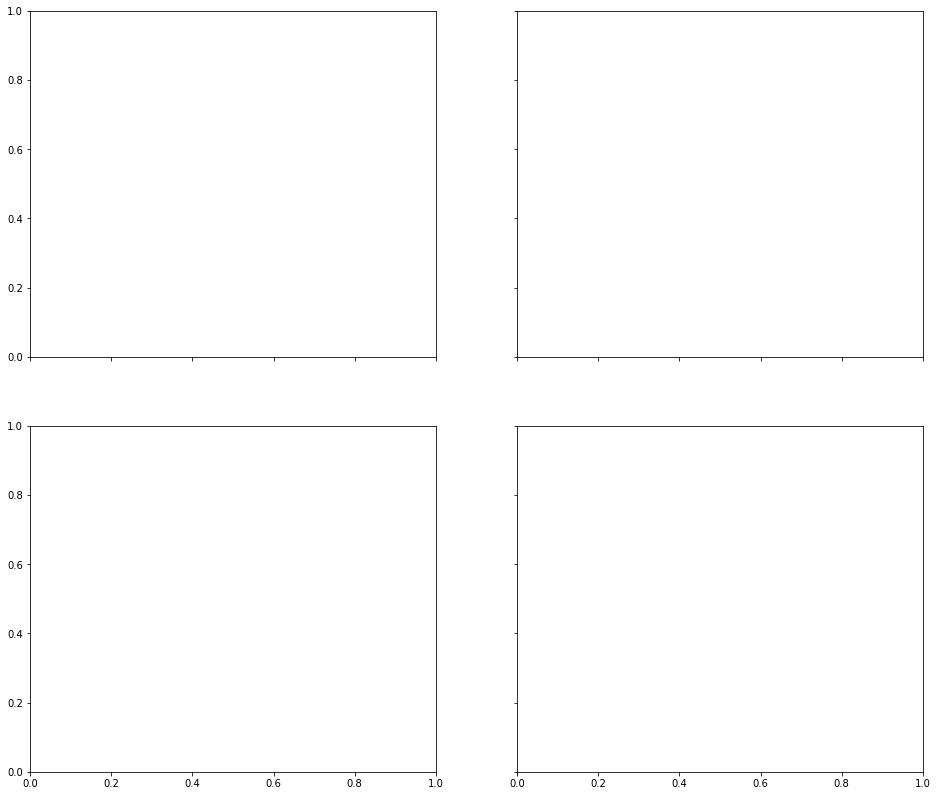

In [47]:
import seaborn as sns


fig, axes = plt.subplots(2,2,figsize=(16,14), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 60, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 60), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,60,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

In [48]:
# 1. Wordcloud of Top N words in each topic
from wordcloud import WordCloud

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=100,
                  colormap='tab20',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(2, 5, figsize=(16,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

NameError: name 'stop_words' is not defined

In [ ]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in word_tokenized_corpus for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True)
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()